# Определение возраста покупателей

## Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

## Описание данных

Признаки:
- file_name	(название фотографии человека в формате jpg)

Целевой признак:
- real_age (возраст человека на соответствующей фотографии)

## Исследовательский анализ данных

### Подключение библиотек

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib.pyplot import imshow, show
from scipy.stats import skew
import matplotlib.pyplot as plt
import numpy as np

### Подключение датафрейма

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
first_datagen = ImageDataGenerator(rescale=1./255)
first_gen_flow = first_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


### Анализ распределения

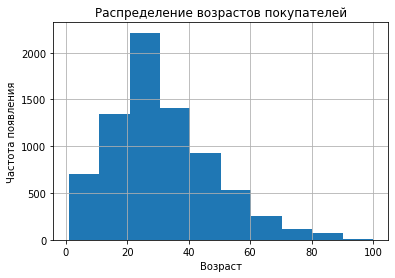

In [3]:
labels['real_age'].hist()
plt.title('Распределение возрастов покупателей')
plt.xlabel('Возраст')
plt.ylabel('Частота появления')
show()

In [4]:
skew(labels.real_age)

0.7294643318901911

In [5]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [6]:
labels.median()

real_age    29.0
dtype: float64

По полученным гистограмме и коэфициенту скошенности, можно сделать вывод, что распределение смещено влево. Среднее, медиана и мода примерно равны 30 годам.

### Исследование датафрейма

In [7]:
features, target = first_gen_flow.next()

In [8]:
labels

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
...,...,...
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20


In [9]:
labels.shape

(7591, 2)

In [10]:
features.shape

(32, 224, 224, 3)

In [11]:
target.shape

(32,)

Выборка из 7591 фотографий разбита на 237 батчей по 32 фотографии в каждом. Фотографии с 3-мя каналами, высотой и шириной в 224 пикселя.

Пример: (первая фотография)

In [12]:
features[0, :, :, :]

array([[[0.5764706 , 0.5137255 , 0.454902  ],
        [0.53333336, 0.47058827, 0.41176474],
        [0.5294118 , 0.4666667 , 0.40784317],
        ...,
        [0.48235297, 0.4156863 , 0.30588236],
        [0.49411768, 0.427451  , 0.31764707],
        [0.49803925, 0.43137258, 0.32156864]],

       [[0.5176471 , 0.454902  , 0.39607847],
        [0.5058824 , 0.4431373 , 0.38431376],
        [0.5529412 , 0.4901961 , 0.43137258],
        ...,
        [0.49803925, 0.43137258, 0.32156864],
        [0.50980395, 0.4431373 , 0.33333334],
        [0.50980395, 0.4431373 , 0.33333334]],

       [[0.5176471 , 0.45098042, 0.38823533],
        [0.5058824 , 0.43921572, 0.37647063],
        [0.5176471 , 0.45098042, 0.38823533],
        ...,
        [0.5019608 , 0.43529415, 0.3254902 ],
        [0.50980395, 0.4431373 , 0.33333334],
        [0.5058824 , 0.43921572, 0.32941177]],

       ...,

       [[0.06666667, 0.45882356, 0.52156866],
        [0.08235294, 0.47450984, 0.5372549 ],
        [0.04705883, 0

In [13]:
target[0]

50

### Проверка разметки

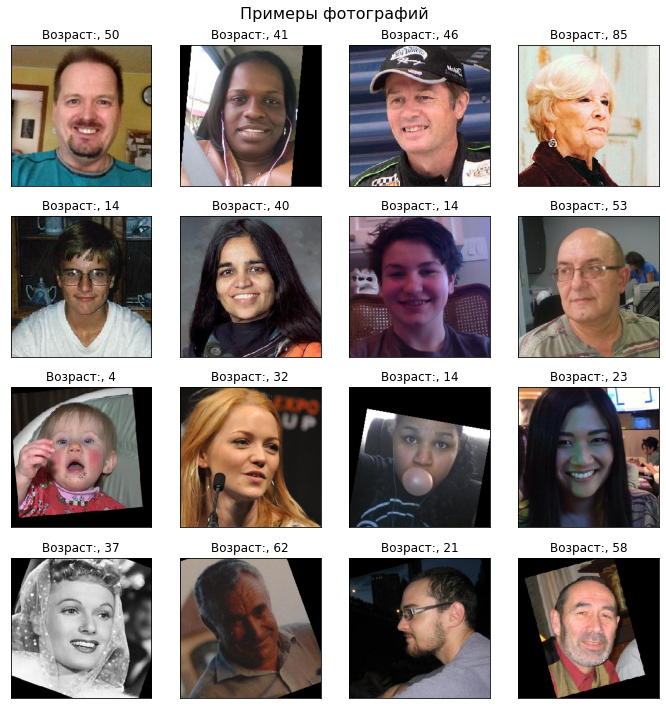

In [14]:
fig = plt.figure(figsize=(10, 10))
fig.suptitle('Примеры фотографий', fontsize=16)
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    imshow(features[i, :, :, :])
    plt.title(f'Возраст:, {target[i]}', fontsize=12)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
show()

По небольшой подвыборке, можно предположить, что фотографии размечены верно.

Неравномерное распределение, может привести к тому, что модель будет 'тяготеть' к среднему значению при предсказаниях, и лучше предсказывать, тех людей, возраст которых ближе к среднему.

Повернутые фотографии также могут негативно сказаться на качестве модели.

## Обучение модели

Код обучения модели:

```python
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from pandas import read_csv
from tensorflow.keras.applications.resnet import ResNet50
SEED = 41626


def load_train(path):
    train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=read_csv(path + 'labels.csv'),
        directory=path + '/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=SEED,
        subset='training')
    return train_datagen_flow


def load_test(path):
    test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=read_csv(path + 'labels.csv'),
        directory=path + '/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=SEED,
        subset='validation')
    return test_datagen_flow


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False)
    model = Sequential()
    optimizer = Adam(lr=0.0003)
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=6, steps_per_epoch=None, validation_steps=None):
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
    return model

```

Вывод модели:

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
Train for 178 steps, validate for 60 steps
Epoch 1/6
178/178 - 65s - loss: 194.0179 - mae: 10.2033 - val_loss: 431.5575 - val_mae: 15.5913
Epoch 2/6
178/178 - 51s - loss: 83.1961 - mae: 6.9004 - val_loss: 625.1932 - val_mae: 19.7821
Epoch 3/6
178/178 - 50s - loss: 43.9103 - mae: 5.0969 - val_loss: 310.7123 - val_mae: 12.9354
Epoch 4/6
178/178 - 48s - loss: 30.9206 - mae: 4.2715 - val_loss: 130.0322 - val_mae: 8.8208
Epoch 5/6
178/178 - 48s - loss: 20.4810 - mae: 3.4745 - val_loss: 99.3383 - val_mae: 7.5110
Epoch 6/6
178/178 - 49s - loss: 14.7550 - mae: 2.9619 - val_loss: 80.3391 - val_mae: 6.6589
60/60 - 10s - loss: 80.3391 - mae: 6.6589
Test MAE: 6.6589
```

## Анализ обученной модели

В качестве модели используется архитектура ResNet50 с алгоритмом Adam при начальном шаге обучения в 0.0003, функцией ошибки MSE; финальная оценка модели дается на основании метрики MAE. MAE обученной модели < 8, следовательно модель может быть использована для решения первой поставленной задачи:
- Предлагать товары, которые могут заинтересовать покупателей, основываясь на предсказанных по их фотографиям возрастных группах.

Однако для второй задачи, модель может не подойдти из-за высокой погрешности:
- Контролировать добросовестность кассиров при продаже алкоголя, предсказывая возраст покупателей.

Эту проблему можно решить снизив погрешность модели.
В этом могут помочь:
- Приведение возрастов к равномерному распределению, благодаря up/down-scalling или добавлению в выборку новых фотографий.
- Стратифицированное разбитие выборки на обучающую и тестовую, чтобы распределения совпадали.
- Точечные аугментации для повернутых фотографий.

Также важно отметить, что для второй задачи, лучше использовать задачу классификации (где класс 1 - можно продавать, класс 0 - нельзя продавать), заранее устранив дисбаланс классов.